# Policy Gradients and REINFORCE


Goal for the session:

Use the setting of last week to study Policy Gradients

Hédi Hadiji April 2023  

In [7]:
# Imports
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from copy import deepcopy
import gymnasium as gym


import time
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

import matplotlib.pyplot as plt

In [8]:
print(f"python --version = {sys.version}")
print(f"torch.__version__ = {torch.__version__}")
print(f"np.__version__ = {np.__version__}")
print(f"gym.__version__ = {gym.__version__}")

python --version = 3.9.15 (main, Nov 24 2022, 08:29:02) 
[Clang 14.0.6 ]
torch.__version__ = 2.0.0
np.__version__ = 1.22.4
gym.__version__ = 0.27.1


# Setting up the agent

### Baselines and utilities

In [9]:
class RandomAgent: 
    def __init__(self, observation_space, action_space):
        self.action_space = action_space
        return
    
    def get_action(self, state, **kwargs):
        return self.action_space.sample()
    
    def update(self, *data):
        pass

## Evaluating the Agent

In [10]:
def eval_agent(agent, env, n_sim=10):
    """    
    Monte Carlo evaluation of the agent.

    Repeat n_sim times:
        * Run the agent policy until the environment reaches a terminal state (= one episode)
        * Compute the sum of rewards in this episode
        * Store the sum of rewards in the episode_rewards array.
    """
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)
    for i in range(n_sim):
        state, _ = env_copy.reset()
        reward_sum = 0
        done = False
        while not done: 
            action = agent.get_action(state, epsilon=0)
            state, reward, terminated, truncated, _ = env_copy.step(action)
            reward_sum += reward
            done = terminated or truncated
        episode_rewards[i] = reward_sum
    return episode_rewards

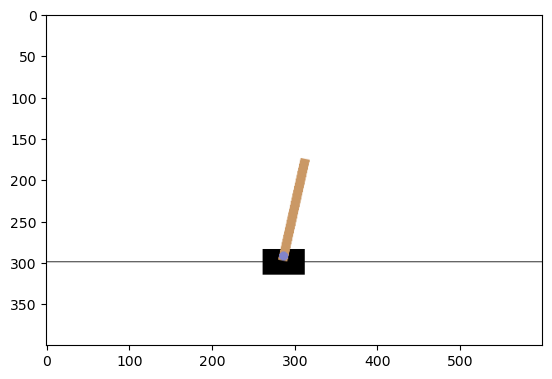

Episode length 20.0
Average over 5 runs : 21.4


In [11]:
env = gym.make("CartPole-v1", render_mode='rgb_array')
agent = RandomAgent(env.observation_space, env.action_space)

def run_one_episode(env, agent, display=True):
    display_env = deepcopy(env)
    done = False
    state, _ = display_env.reset()

    rewards = 0

    while not done:
        action = agent.get_action(state, epsilon=0)
        state, reward, done, _, _ = display_env.step(action)
        rewards += reward
        if display: 
            clear_output(wait=True)
            plt.imshow(display_env.render())
            plt.show()
    if display:
        display_env.close()
    print(f'Episode length {rewards}')
    
run_one_episode(env, agent, display=True)
print(f'Average over 5 runs : {np.mean(eval_agent(agent, env))}')

In [12]:
def train(env, agent, N_episodes, eval_every=100, reward_threshold=300, n_eval=10):
    total_time = 0
    for ep in range(N_episodes):
        done = False
        state, _ = env.reset()
        while not done: 
            action = agent.get_action(state)

            next_state, reward, terminated, truncated, _ = env.step(action)
            agent.update(state, action, reward, terminated, next_state)

            state = next_state

            done = terminated or truncated
            total_time += 1

        if ((ep+1)% eval_every == 0):
            mean_reward = np.mean(eval_agent(agent, env, n_sim=n_eval))
            print("episode =", ep+1, ", reward = ", mean_reward)
            if mean_reward >= reward_threshold:
                break
                
    return 

## Theory Recap

$$
    \nabla J(\theta) \approx \sum_{t=1}^T \gamma^t G_t \nabla \log \pi (A_t \mid S_t, \theta)
$$
where $\approx$ means that we estimate the LHS by the RHS


In this session, the policy is computed to be the softmax of the output of a neural network by 

$$
    \pi(a \vert s, \theta) = \frac{e^{h(s, a; \theta)}}{\sum_{a'} e^{h(s, a'; \theta)} }
$$
where $h(s, \cdot ; \theta)$ is the output of a neural network parameterized by $\theta$ when given the state $s$ as input.

In particular
$$
    \log \pi(a \vert s, \theta) = h(s, a; \theta) - \log \bigg( \sum_{a'} e^{h(s, a'; \theta)} \bigg)
$$


`self.policy_net(state)` est un tenseur qui représente $h(s, \cdot \,; \theta)$ si `state` est $s$.

In [15]:
class Net(nn.Module):
    """
    Basic neural net.
    """

    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions),
        )

    def forward(self, x):
        return self.net(x)

Question: Implement the get_action method

In [ ]:
class REINFORCE_SKELETON:
    def __init__(
        self,
        action_space,
        observation_space,
        gamma,
        episode_batch_size,
        learning_rate,
    ):
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma

        self.episode_batch_size = episode_batch_size
        self.learning_rate = learning_rate

        self.reset()

    def update(self, state, action, reward, terminated, next_state):
        pass
    

    def get_action(self, state, epsilon=None):
        """
            QUESTION: 
        """
        state_tensor = torch.tensor(state).unsqueeze(0)
        with torch.no_grad():
            #Your code here
            pass


    def reset(self):
        hidden_size = 128

        obs_size = self.observation_space.shape[0]
        n_actions = self.action_space.n

        self.policy_net = Net(obs_size, hidden_size, n_actions)

        self.scores = []
        self.current_episode = []

        self.optimizer = optim.Adam(
            params=self.policy_net.parameters(), lr=self.learning_rate
        )

        self.n_eps = 0


In [13]:
class REINFORCE_SKELETON:
    def __init__(
        self,
        action_space,
        observation_space,
        gamma,
        episode_batch_size,
        learning_rate,
    ):
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma

        self.episode_batch_size = episode_batch_size
        self.learning_rate = learning_rate

        self.reset()

    def update(self, state, action, reward, terminated, next_state):
        pass
    

    def get_action(self, state, epsilon=None):
        """
            SOLUTION
        """
        state_tensor = torch.tensor(state).unsqueeze(0)
        with torch.no_grad():
            unn_log_probs = self.policy_net.forward(state_tensor).numpy()[0]
            p = np.exp(unn_log_probs - np.min(unn_log_probs))
            p = p / np.sum(p)
            return np.random.choice(np.arange(self.action_space.n), p=p)


    def reset(self):
        hidden_size = 128

        obs_size = self.observation_space.shape[0]
        n_actions = self.action_space.n

        self.policy_net = Net(obs_size, hidden_size, n_actions)

        self.scores = []
        self.current_episode = []

        self.optimizer = optim.Adam(
            params=self.policy_net.parameters(), lr=self.learning_rate
        )

        self.n_eps = 0

You should have an agent that runs but does not learn

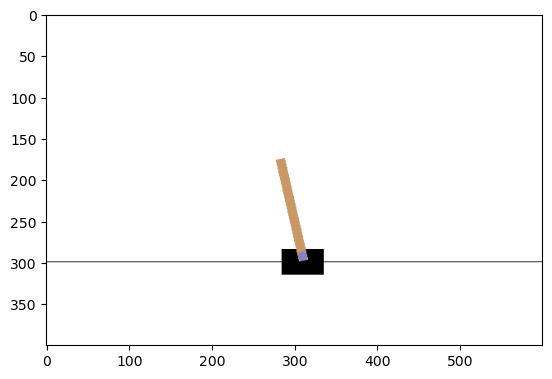

Episode length 21.0


In [17]:
action_space = env.action_space
observation_space = env.observation_space
gamma = 0.99
episode_batch_size = 1
learning_rate = 1e-2

agent = REINFORCE_SKELETON(action_space,
        observation_space,
        gamma,
        episode_batch_size,
        learning_rate,)

run_one_episode(env, agent, display=True)

Time to implement the gradient updates. 

Remember you want to take 
$$
    \theta \leftarrow \theta + \eta_t \sum_{t=1}^T \gamma^t G_t \nabla_{\theta} \log \pi(A_t \vert S_t, \theta)
$$
the RHS is equal to 
$$
    \theta + \eta_t \nabla_{\theta} \bigg(\sum_{t=1}^T \gamma^t G_t \log \pi(A_t \vert S_t, \theta)\bigg) \, . 
$$

In [60]:
class REINFORCE(REINFORCE_SKELETON):
    
    def _gradient_returns(self, rewards, gamma):
        """
        Turns a list of rewards into the list of returns * gamma**t
        """
        G = 0
        returns_list = []
        T = len(rewards)
        full_gamma = np.power(gamma, T)
        for t in range(T):
            G = rewards[T-t-1] + gamma * G
            full_gamma /= gamma
            returns_list.append(full_gamma * G)
        return torch.tensor(returns_list[::-1])#, dtype=torch.float32)

    def update(self, state, action, reward, terminated, next_state):
        """
        ** Question **
        """
        
        self.current_episode.append((
            torch.tensor(state).unsqueeze(0),
            torch.tensor([[action]], dtype=torch.int64),
            torch.tensor([reward]),
        )
        )

        if terminated: 
            self.n_eps += 1
            # Your code here

            #1 Récupérer les states, actions, rewards de l'épisode

            #2 Calculer la suite \gamma^t G_t (dans un tenseur)

            #3 Calculer la suite \log \pi (A_t | S_t, \theta)
            
            #4 Calculer \sum \gamma^t G_t \log \pi (A_t | S_t, \theta)

            #5 Faire l'étape de montée de gradient
            


In [23]:
class REINFORCE(REINFORCE_SKELETON):
    
    def _gradient_returns(self, rewards, gamma):
        """
        Turns a list of rewards into the list of returns * gamma**t
        """
        G = 0
        returns_list = []
        T = len(rewards)
        full_gamma = np.power(gamma, T)
        for t in range(T):
            G = rewards[T-t-1] + gamma * G
            full_gamma /= gamma
            returns_list.append(full_gamma * G)
        return torch.tensor(returns_list[::-1])#, dtype=torch.float32)

    def update(self, state, action, reward, terminated, next_state):
        """
        ** SOLUTION **
        """
        
        self.current_episode.append((
            torch.tensor(state).unsqueeze(0),
            torch.tensor([[action]], dtype=torch.int64),
            torch.tensor([reward]),
        )
        )

        if terminated: 
            self.n_eps += 1

            states, actions, rewards = tuple(
                [torch.cat(data) for data in zip(*self.current_episode)]
            )

            current_episode_returns = self._gradient_returns(rewards, self.gamma)

            unn_log_probs = self.policy_net.forward(states)
            log_probs = unn_log_probs - torch.log(torch.sum(torch.exp(unn_log_probs), dim=1)).unsqueeze(1)


            full_neg_score = - torch.dot(log_probs.gather(1, actions).squeeze(), current_episode_returns).unsqueeze(0)#).sum()


            self.current_episode = []

            self.optimizer.zero_grad()
            full_neg_score.backward()
            self.optimizer.step()

In [25]:
env = gym.make("CartPole-v1", render_mode='rgb_array')

action_space = env.action_space
observation_space = env.observation_space

gamma = .95
episode_batch_size = 1
learning_rate = 1e-2

agent = REINFORCE(
        action_space,
        observation_space,
        gamma,
        episode_batch_size,
        learning_rate,
        )
N_episodes = 300


print("mean reward before training = ", np.mean(eval_agent(agent, env, 200)))
# Run the training loop
train(env, agent, N_episodes, eval_every=50,)

# Evaluate the final policy
print("mean reward after training = ", np.mean(eval_agent(agent, env, 200)))

mean reward before training =  21.85
episode = 50 , reward =  24.9
episode = 100 , reward =  42.2
episode = 150 , reward =  56.9
episode = 200 , reward =  37.6
episode = 250 , reward =  49.7
episode = 300 , reward =  104.0
mean reward after training =  79.095


In practice, one way to stabilize the updates is to wait a few episodes before doing the updates in batch. Implement this.

In [ ]:
class REINFORCEBatch(REINFORCE):
    def update(self, state, action, reward, terminated, next_state):
        """
        ** QUESTION **
        """
        
        self.current_episode.append((
            torch.tensor(state).unsqueeze(0),
            torch.tensor([[action]], dtype=torch.int64),
            torch.tensor([reward]),
        )
        )

        if terminated:
            self.n_eps += 1
            # Your code here

            if (self.n_eps % self.episode_batch_size)==0:
               # Your code here
               pass


In [26]:
class REINFORCEBatch(REINFORCE):
    def update(self, state, action, reward, terminated, next_state):
        """
        ** SOLUTION **
        """
        
        self.current_episode.append((
            torch.tensor(state).unsqueeze(0),
            torch.tensor([[action]], dtype=torch.int64),
            torch.tensor([reward]),
        )
        )

        if terminated:
            self.n_eps += 1

            states, actions, rewards = tuple(
                [torch.cat(data) for data in zip(*self.current_episode)]
            )

            current_episode_returns = self._gradient_returns(rewards, self.gamma)

            unn_log_probs = self.policy_net.forward(states)
            log_probs = unn_log_probs - torch.log(torch.sum(torch.exp(unn_log_probs), dim=1)).unsqueeze(1)
            self.scores.append(torch.dot(log_probs.gather(1, actions).squeeze(), current_episode_returns).unsqueeze(0))
            self.current_episode = []

            if (self.n_eps % self.episode_batch_size)==0:
                self.optimizer.zero_grad()
                full_neg_score = - torch.cat(self.scores).sum() / self.episode_batch_size
                full_neg_score.backward()
                self.optimizer.step()
                
                self.scores = []


In [27]:
env = gym.make("CartPole-v1", render_mode='rgb_array')

action_space = env.action_space
observation_space = env.observation_space

gamma = .95
episode_batch_size = 5
learning_rate = 1e-2

agent = REINFORCEBatch(
        action_space,
        observation_space,
        gamma,
        episode_batch_size,
        learning_rate,
        )
N_episodes = 300


print("mean reward before training = ", np.mean(eval_agent(agent, env, 200)))
# Run the training loop
train(env, agent, N_episodes, eval_every=50,)

# Evaluate the final policy
print("mean reward after training = ", np.mean(eval_agent(agent, env, 200)))

mean reward before training =  25.375
episode = 50 , reward =  33.8
episode = 100 , reward =  35.5
episode = 150 , reward =  79.6
episode = 200 , reward =  62.7
episode = 250 , reward =  83.7
episode = 300 , reward =  117.4
mean reward after training =  109.86


Baseline:

Remember we can add a baseline to reduce the variance. The simplest baseline one can take it use 
$$
    b(S_t) \equiv \bar G_T = \frac{1}{T} \sum_{t=1}^T G_t
$$
which amount to subtracting the mean of the returns in the estimation to use 

$$
        \theta \leftarrow \theta + \eta_t \sum_{t=1}^T \gamma^t (G_t - \bar G_T) \nabla_{\theta} \log \pi(A_t \vert S_t, \theta)
$$

In [28]:
class REINFORCEBaseline(REINFORCE):
    def update(self, state, action, reward, terminated, next_state):
        """
        ** QUESTION **
        """
        
        self.current_episode.append((
            torch.tensor(state).unsqueeze(0),
            torch.tensor([[action]], dtype=torch.int64),
            torch.tensor([reward]),
        )
        )

        if terminated:
            # Your code here
            pass

In [29]:
class REINFORCEBaseline(REINFORCE):
    def update(self, state, action, reward, terminated, next_state):
        """
        ** SOLUTION **
        """
        
        self.current_episode.append((
            torch.tensor(state).unsqueeze(0),
            torch.tensor([[action]], dtype=torch.int64),
            torch.tensor([reward]),
        )
        )

        if terminated:
            self.n_eps += 1

            states, actions, rewards = tuple(
                [torch.cat(data) for data in zip(*self.current_episode)]
            )

            current_episode_returns = self._gradient_returns(rewards, self.gamma)
            current_episode_returns = (current_episode_returns - current_episode_returns.mean())

            unn_log_probs = self.policy_net.forward(states)
            log_probs = unn_log_probs - torch.log(torch.sum(torch.exp(unn_log_probs), dim=1)).unsqueeze(1)
            self.scores.append(torch.dot(log_probs.gather(1, actions).squeeze(), current_episode_returns).unsqueeze(0))
            self.current_episode = []

            if (self.n_eps % self.episode_batch_size)==0:
                self.optimizer.zero_grad()
                full_neg_score = - torch.cat(self.scores).sum() / self.episode_batch_size
                full_neg_score.backward()
                self.optimizer.step()
                
                self.scores = []


In [30]:
env = gym.make("CartPole-v1", render_mode='rgb_array')

action_space = env.action_space
observation_space = env.observation_space

gamma = .95
episode_batch_size = 10
learning_rate = 1e-2

agent = REINFORCEBaseline(
        action_space,
        observation_space,
        gamma,
        episode_batch_size,
        learning_rate,
        )
N_episodes = 300


print("mean reward before training = ", np.mean(eval_agent(agent, env, 200)))
# Run the training loop
train(env, agent, N_episodes, eval_every=50,)

# Evaluate the final policy
print("mean reward after training = ", np.mean(eval_agent(agent, env, 200)))

mean reward before training =  22.555
episode = 50 , reward =  29.6
episode = 100 , reward =  41.8
episode = 150 , reward =  58.2
episode = 200 , reward =  46.1
episode = 250 , reward =  53.8
episode = 300 , reward =  78.3
mean reward after training =  83.385


In [31]:
class REINFORCE:
    def __init__(
        self,
        action_space,
        observation_space,
        gamma,
        episode_batch_size,
        learning_rate,
    ):
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma

        self.episode_batch_size = episode_batch_size
        self.learning_rate = learning_rate

        self.reset()

    def update(self, state, action, reward, terminated, next_state):
        """
        ** SOLUTION **
        """

        self.current_episode.append((
            torch.tensor(state).unsqueeze(0),
            torch.tensor([[action]], dtype=torch.int64),
            torch.tensor([reward]),
        )
        )

        if terminated:
            self.n_eps += 1

            states, actions, rewards = tuple(
                [torch.cat(data) for data in zip(*self.current_episode)]
            )

            current_episode_returns = self._gradient_returns(rewards, self.gamma)
            current_episode_returns = (current_episode_returns - current_episode_returns.mean())

            unn_log_probs = self.policy_net.forward(states)
            log_probs = unn_log_probs - torch.log(torch.sum(torch.exp(unn_log_probs), dim=1)).unsqueeze(1)
            self.scores.append(torch.dot(log_probs.gather(1, actions).squeeze(), current_episode_returns).unsqueeze(0))
            self.current_episode = []

            if (self.n_eps % self.episode_batch_size)==0:
                self.optimizer.zero_grad()
                full_neg_score = - torch.cat(self.scores).sum() / self.episode_batch_size
                full_neg_score.backward()
                self.optimizer.step()
                
                self.scores = []

        return  
    
    def _gradient_returns(self, rewards, gamma):
        """
        Turns a list of rewards into the list of returns * gamma**t
        """
        G = 0
        returns_list = []
        T = len(rewards)
        full_gamma = np.power(gamma, T)
        for t in range(T):
            G = rewards[T-t-1] + gamma * G
            full_gamma /= gamma
            returns_list.append(full_gamma * G)
        return torch.tensor(returns_list[::-1])#, dtype=torch.float32)

    def get_action(self, state, epsilon=None):
        """
        Return action according to an epsilon-greedy exploration policy
        """
        state_tensor = torch.tensor(state).unsqueeze(0)
        with torch.no_grad():
            unn_log_probs = self.policy_net.forward(state_tensor).numpy()[0]
            p = np.exp(unn_log_probs - np.min(unn_log_probs))
            p = p /  np.sum(p)
            return np.random.choice(np.arange(self.action_space.n), p=p)


    def reset(self):
        hidden_size = 128

        obs_size = self.observation_space.shape[0]
        n_actions = self.action_space.n

        self.policy_net = Net(obs_size, hidden_size, n_actions)

        self.scores = []
        self.current_episode = []

        self.optimizer = optim.Adam(
            params=self.policy_net.parameters(), lr=self.learning_rate
        )

        self.n_eps = 0


In [32]:
print("Rewards after training = ", eval_agent(agent, env, n_sim = 10))
print("Rewards Random = ", eval_agent(RandomAgent(observation_space, action_space), env, n_sim = 10))

Rewards after training =  [ 57.  39.  86.  83.  53. 171.  45.  64.  64. 164.]
Rewards Random =  [15. 15. 12. 24. 17. 16. 23. 14. 14. 31.]


In [18]:
# Some 

# a = np.eye(3)
# for i in range(3): a[i, i] = i

# unn_log_probs = torch.tensor(a)#.unsqueeze(0)
# #print(unn_log_probs)
# print(unn_log_probs.shape)
# print(torch.log(torch.sum(torch.exp(unn_log_probs), dim=[1])).unsqueeze(1).shape)
# log_probs = unn_log_probs - torch.log(torch.sum(torch.exp(unn_log_probs), dim=1)).unsqueeze(1)

# print(unn_log_probs)
# print(torch.log(torch.sum(torch.exp(unn_log_probs), dim=[1])).unsqueeze(1))
# print(log_probs)

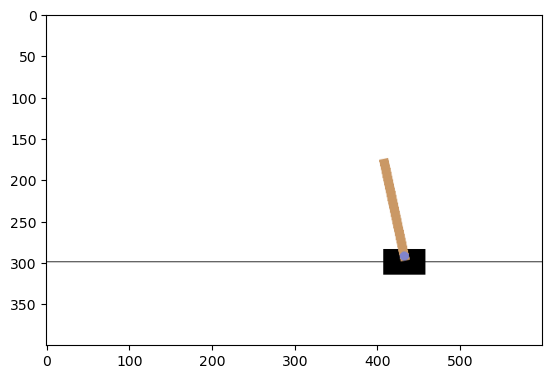

Episode length 218.0


In [153]:
run_one_episode(env, agent, display=True)